In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xg
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2
from sklearn.model_selection import train_test_split
import numpy as np
from xgboost import cv
import os
import warnings
warnings.filterwarnings('ignore')

from data_loader import load_datasets, nee_cumulative_to_daily, to_pd

### A Recursive Feature Elimination (RFE) model with automatic tuning of the number of features selected with cross-validation.

In [2]:
target = 'NEE'

In [3]:
dirs = ['warm_temp_maize_soybean_irrigated', 'warm_temp_maize-soybean_dryland', 'cool_temp_maize_soybean']

datasets = load_datasets(dirs, '/csv_outs/with_plant_soil_details/')
observed_df = pd.read_csv('datasets/extractedNEE_CUT_REF_NIGHT_Final'  + '.csv')

df_dry = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize-soybean_dryland'], True, True))
df_irr = nee_cumulative_to_daily(to_pd(datasets['warm_temp_maize_soybean_irrigated'], True, True))
df_cool = nee_cumulative_to_daily(to_pd(datasets['cool_temp_maize_soybean'], True, True))

df = pd.concat([df_dry,df_irr, df_cool])

y = df[target].copy()

soil_prfl_vars = [
  "initial bulk density (Mg m-3,0=water) ",
  "sand contents (kg Mg-1)",
  "silt contents (kg Mg-1)",
  "rock fraction" ,
  "ph",
  "SOC (kg Mg-1)" ]

planting =  ['planting date', 'initial planting density (m-2)', 'seeding depth (m)']
observed_df = observed_df.reset_index()
planting_df = pd.DataFrame()
for plt in planting:
    filter_col = [col for col in df if plt in col]
    planting_df[filter_col] = df[filter_col] 

    
plant_soil_df = pd.concat( [planting_df, df[soil_prfl_vars]], axis = 1 )
weather_forcings = observed_df.columns.drop(['index', 'Unnamed: 0'])

df_final = pd.concat([df[weather_forcings], plant_soil_df], axis=1)

In [24]:
df_final.shape

(8766, 36)

In [23]:
plant_soil_df

,planting date1,planting date2,planting date3,planting date4,planting date5,planting date6,initial planting density (m-2)1,initial planting density (m-2)2,initial planting density (m-2)3,initial planting density (m-2)4,...,seeding depth (m)3,seeding depth (m)4,seeding depth (m)5,seeding depth (m)6,"initial bulk density (Mg m-3,0=water)",sand contents (kg Mg-1),silt contents (kg Mg-1),rock fraction,ph,SOC (kg Mg-1)
0,14052001,20052002,13052003,2062004,26042005,11052006,6.2,37.1,6.5,37.1,...,0.020,0.020,0.020,0.020,1.268333,79.583333,656.083333,0.0,6.013333,13.341667
1,14052001,20052002,13052003,2062004,26042005,11052006,6.2,37.1,6.5,37.1,...,0.020,0.020,0.020,0.020,1.268333,79.583333,656.083333,0.0,6.013333,13.341667
2,14052001,20052002,13052003,2062004,26042005,11052006,6.2,37.1,6.5,37.1,...,0.020,0.020,0.020,0.020,1.268333,79.583333,656.083333,0.0,6.013333,13.341667
3,14052001,20052002,13052003,2062004,26042005,11052006,6.2,37.1,6.5,37.1,...,0.020,0.020,0.020,0.020,1.268333,79.583333,656.083333,0.0,6.013333,13.341667
4,14052001,20052002,13052003,2062004,26042005,11052006,6.2,37.1,6.5,37.1,...,0.020,0.020,0.020,0.020,1.268333,79.583333,656.083333,0.0,6.013333,13.341667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2917,18051998,21051999,29052000,26042001,22052002,21052003,6.6,37.5,6.6,250.0,...,0.025,0.025,0.025,0.025,1.288000,350.000000,341.400000,0.0,6.640000,9.585000
2918,18051998,21051999,29052000,26042001,22052002,21052003,6.6,37.5,6.6,250.0,...,0.025,0.025,0.025,0.025,1.288000,350.000000,341.400000,0.0,6.640000,9.585000
2919,18051998,21051999,29052000,26042001,22052002,21052003,6.6,37.5,6.6,250.0,...,0.025,0.025,0.025,0.025,1.288000,350.000000,341.400000,0.0,6.640000,9.585000
2920,18051998,21051999,29052000,26042001,22052002,21052003,6.6,37.5,6.6,250.0,...,0.025,0.025,0.025,0.025,1.288000,350.000000,341.400000,0.0,6.640000,9.585000


In [5]:
y = df_final['NEE'].copy()
x = df_final.drop(['NEE', 'DATE'], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
   x, y, test_size=0.33, random_state=41)

In [22]:
x['planting_date1']

KeyError: 'planting_date1'

RANDOM FOREST

In [ ]:
min_features_to_select = 1  # Minimum number of features to consider

cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
clf = RandomForestRegressor(criterion = "absolute_error", random_state =1)

rfecv = RFECV(
    estimator=clf,
    step=1,
    cv=cv,
    scoring="neg_mean_squared_error",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)
rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

XGBOOST

In [27]:
min_features_to_select = 1  # Minimum number of features to consider

cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
reg = xg.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 10, seed = 123)

rfecv = RFECV(
    estimator=reg,
    step=1,
    cv=cv,
    scoring="r2",
    min_features_to_select=min_features_to_select,
    n_jobs=2,
)

rfecv.fit(X_train, y_train)

print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 11


In [28]:
base_estimator = str(rfecv.estimator).split('(')[0]


path_to_save = 'feature_analysis/' + 'rcef_'+ base_estimator
os.makedirs(path_to_save , exist_ok=True)  

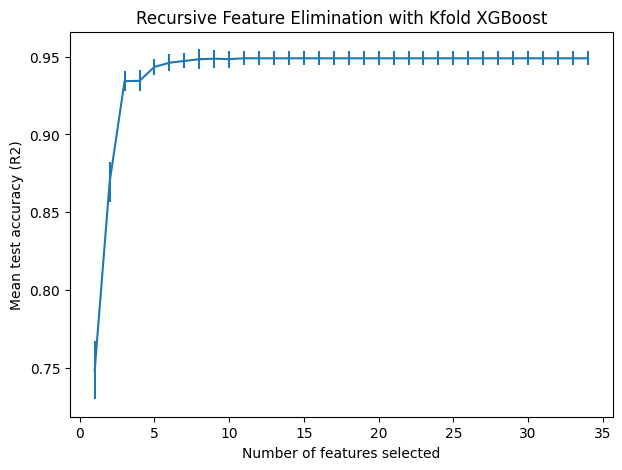

In [29]:
n_scores = len(rfecv.cv_results_["mean_test_score"])
fig = plt.figure(figsize=(7,5))
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy (R2)")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination with Kfold XGBoost")
plt.show()


base_estimator = str(rfecv.estimator).split('(')[0]

In [31]:
fig.savefig(os.path.join(path_to_save, target + '_' + base_estimator ), format='png')

In [14]:
importances = pd.DataFrame({'RANK': rfecv.ranking_}, index=rfecv.feature_names_in_).sort_values(by='RANK', ascending=True)

In [15]:
importances=importances[importances['RANK'] == 1]

In [16]:
importances

,RANK
DOY,1
HMAX_AIR,1
TMIN_AIR,1
TMAX_SOIL,1
HMIN_AIR,1
TMAX_AIR,1
RADN,1
WIND,1
D_W_PRECN,1
TMIN_SOIL,1


In [17]:
importances.to_csv('feature_analysis/' + 'rcef_' + base_estimator + '/FeaturesImportances' + target + '.csv')  

In [ ]:
# RMSE Computation
rmse = np.sqrt(MSE(y_cool, pred_col))
print("RMSE : % f" %(rmse))
plt.scatter(pred_col, y_dry)

In [ ]:
for i in range(x.shape[1]):
 print('Column: %s, Selected %s, Rank: %.3f' % (rfecv.feature_names_in_[i], rfecv.support_[i], rfecv.ranking_[i]))